In [7]:
!hostname

dhbw


In [8]:
!nvidia-smi

Sun Mar  9 17:41:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTXA6000-4C             On  |   00000000:06:10.0 Off |                    0 |
| N/A   N/A    P8             N/A /  N/A  |       1MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
import subprocess
import sys

# Liste der benötigten Bibliotheken
required_packages = [
    "gymnasium", "numpy", "pandas", "joblib", "scikit-learn", "matplotlib",
    "stable-baselines3", "torch", "torchvision", "torchaudio"
]

# Funktion zum Installieren fehlender Bibliotheken
def install_packages(packages):
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"📦 Installiere {package} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Installiere fehlende Pakete
install_packages(required_packages)

📦 Installiere scikit-learn ...
📦 Installiere stable-baselines3 ...


In [12]:
import os
print(os.getcwd())  # Gibt den aktuellen Arbeitsordner aus

/home/dhbw


In [19]:
%run /home/dhbw/environment.ipynb

Notebook ausgeführt


In [20]:
import numpy as np
import pandas as pd
import joblib
import random
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.callbacks import CheckpointCallback
from sklearn.preprocessing import StandardScaler
from stable_baselines3.common.vec_env import DummyVecEnv

In [21]:
seed = 42
SEED  = seed % (2**32 - 1)
print(f"SEED: {SEED}")

SEED: 42


In [28]:
# -------------------------------
# CSV Datem einlesen
# -------------------------------
train_data = pd.read_csv("/home/dhbw/2023-2018_stand_data.csv")
train_data.drop('datetime', axis=1, inplace=True)

test_data = pd.read_csv("/home/dhbw/2025-2024_stand_data.csv")
test_data.drop('datetime', axis=1, inplace=True)

if(train_data is not None and test_data is not None):
    print("Daten erfolgreich eingelesen")

Daten erfolgreich eingelesen


In [30]:
# -------------------------------
# TradingEnv erstellen (bitte sicherstellen, dass TradingEnv importiert oder im gleichen Skript definiert ist)
# -------------------------------
env = TradingEnv(
    data=train_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="/home/dhbw/scaler.pkl",
    default_seed=SEED
)

if(env is not None):
    print("Environment created successfully")

Seed in the environment: 42
Environment created successfully


In [ ]:
# -------------------------------
# PPO-Agenten initialisieren
# -------------------------------
model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1, 
    seed=SEED, 
    device="cuda",
#   tensorboard_log="./tensorboard_log/"
)

# Optional: Checkpoint Callback um den Trainingsfortschritt zwischendurch zu speichern
checkpoint_callback = CheckpointCallback(save_freq=100, save_path='./logs/', name_prefix='ppo_trading')

# -------------------------------
# Training
# -------------------------------
model.learn(
    total_timesteps=100, 
    #callback=checkpoint_callback, 
    log_interval=1
)

# Speichere das trainierte Modell
model.save("ppo_trading_model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/dhbw/jupyter-env/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Seed in the environment: 42
-----------------------------
| time/              |      |
|    fps             | 480  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------


# Backtesting

## Trainigsdaten

Seed in the environment: 42


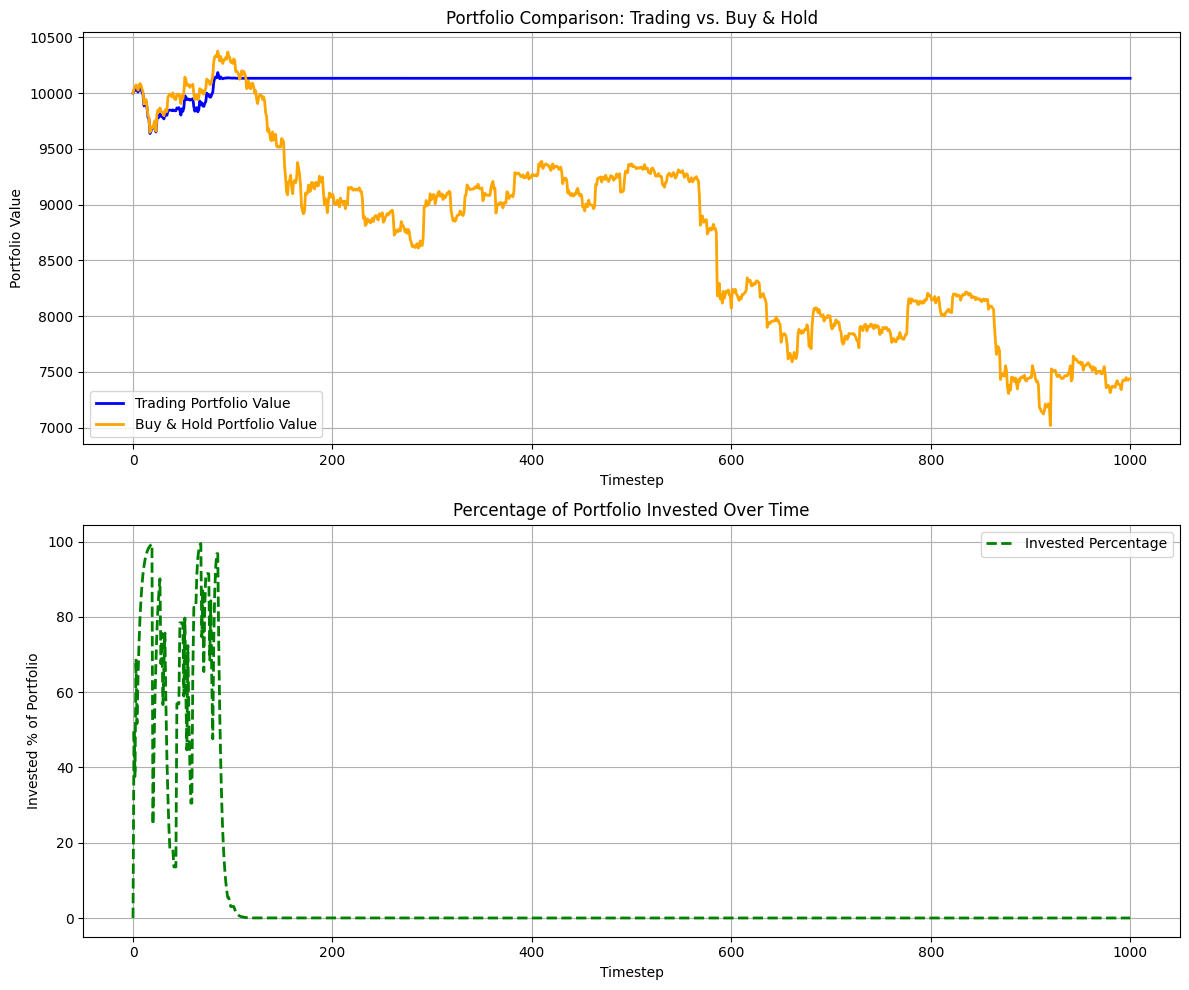

[2, 5, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 5, 5, 5, 5, 5, 0, 0, 0, 5, 0, 0, 2, 0, 0, 2, 0, 0, 0, 5, 2, 5, 5, 2, 5, 5, 5, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 5, 2, 5, 2, 2, 0, 0, 0, 5, 2, 5, 5, 2, 2, 2, 2, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 5, 5, 0, 5, 5, 7, 7, 7, 7, 7, 7, 5, 7, 5, 7, 7, 5, 5, 5, 7, 7, 7, 7, 7, 5, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 0, 0, 7, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 0, 5, 0, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [14]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen
# -------------------------------
training_env = env

obs, info = training_env.reset(seed=SEED)
done = False

# Liste der actionen
action_list = []

#while not done:
for i in range(1000):
    # Bestimme die Aktion (deterministisch)
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    obs, reward, done, truncated, info = training_env.step(action)
    action_list.append(action)

# Hier wird der Zustand gerendert (z.B. als Plot). Du kannst den Render-Modus anpassen.
training_env.render(mode='human')
print(action_list)

## Testdaten

Seed in the environment: 42
Seed in the environment: 42


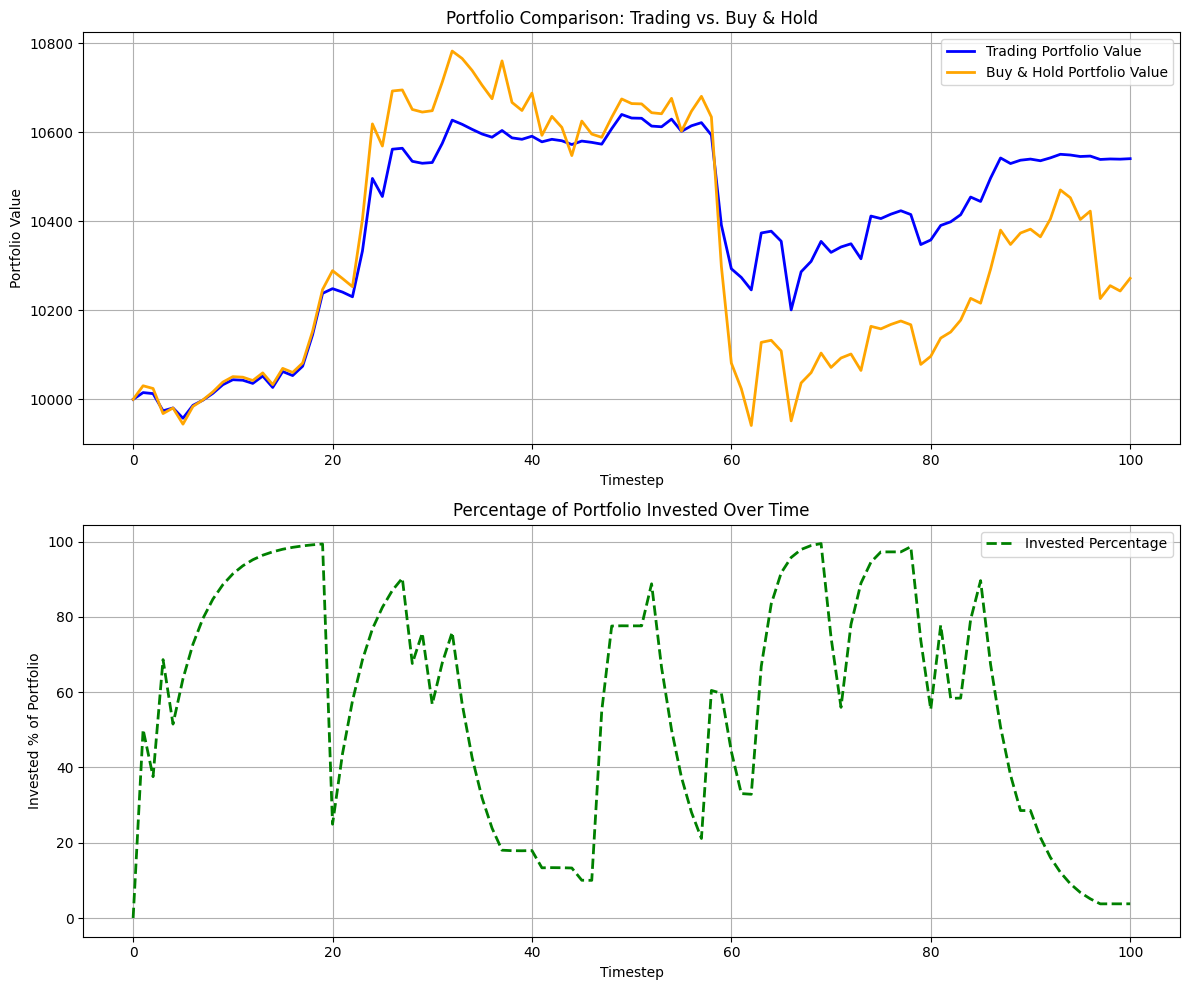

[2, 5, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 5, 5, 5, 5, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 2, 2, 0, 0, 0, 2, 5, 5, 5, 5, 5, 2, 0, 5, 5, 0, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2, 0, 0, 2, 5, 5, 2, 5, 0, 2, 2, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0]


In [15]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen
# -------------------------------
test_env = TradingEnv(
    data=test_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="../../Transform_data/scaler.pkl",
    default_seed=SEED
)

obs, info = test_env.reset(seed=SEED)
done = False

# Liste der actionen
action_list = []

#while not done:
for i in range(100):
    # Bestimme die Aktion (deterministisch)
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    obs, reward, done, truncated, info = test_env.step(action)
    action_list.append(action)

# Hier wird der Zustand gerendert (z.B. als Plot). Du kannst den Render-Modus anpassen.
test_env.render(mode='human')
print(action_list)

# ======

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
#from stable_baselines3.common.callbacks import CheckpointCallback  # Optional, falls benötigt
#from stable_baselines3.common.vec_env import DummyVecEnv


# -------------------------------
# TradingEnv erstellen
# (Stelle sicher, dass TradingEnv bereits importiert oder definiert ist)
# -------------------------------
env = TradingEnv(
    data=train_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="/home/dhbw/scaler.pkl",
    default_seed=SEED
)

test_env = TradingEnv(
    data=test_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="/home/dhbw/scaler.pkl",
    default_seed=SEED
)

print("Environments erstellt")

# -------------------------------
# PPO-Agent initialisieren
# -------------------------------
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    seed=SEED,
    device="cuda",
    #tensorboard_log="./tensorboard_log/"  # Optional: Logging für TensorBoard
)

# Optional: Checkpoint Callback, falls du Zwischenspeicherungen möchtest
# checkpoint_callback = CheckpointCallback(save_freq=100, save_path='./logs/', name_prefix='ppo_trading')

# -------------------------------
# Trainings- und Test-Performance (Loss) evaluieren und plotten
# -------------------------------
# Wir unterteilen das Training in mehrere Intervalle.
eval_interval = 1000          # Trainingsschritte pro Intervall
total_timesteps = 10000       # Gesamtzahl der Trainingsschritte
n_iterations = total_timesteps // eval_interval

# Listen für Plot-Daten
train_loss_list = []  # Wir definieren Loss als negativen Reward (damit "kleiner" besser ist)
test_loss_list = []
timesteps_list = []

# Trainingsschleife in Intervallen
for i in range(1, n_iterations + 1):
    print(f"\n=== Trainingsiteration {i} von {n_iterations} ===")
    
    # Training um 'eval_interval' Timesteps; wichtig: reset_num_timesteps=False, damit die Zählung nicht zurückgesetzt wird!
    model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    
    # Evaluation auf dem Trainings-Environment (mittlere Reward über 5 Episoden)
    mean_train_reward, _ = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
    # Evaluation auf dem Test-Environment
    mean_test_reward, _ = evaluate_policy(model, test_env, n_eval_episodes=5, deterministic=True)
    
    # Um den "Loss" zu erhalten, verwenden wir den negativen Reward.
    train_loss = -mean_train_reward
    test_loss = -mean_test_reward
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    timesteps_list.append(i * eval_interval)
    
    print(f"Timesteps: {i * eval_interval} | Train Reward: {mean_train_reward:.2f} (Loss: {train_loss:.2f}) | Test Reward: {mean_test_reward:.2f} (Loss: {test_loss:.2f})")

# -------------------------------
# Plot: Loss-Kurven (grün: Training, rot: Test)
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(timesteps_list, train_loss_list, color='green', label='Train Loss')
plt.plot(timesteps_list, test_loss_list, color='red', label='Test Loss')
plt.xlabel("Timesteps")
plt.ylabel("Loss (negativer Reward)")
plt.title("Train vs. Test Loss Kurven")
plt.legend()
plt.grid()
plt.show()

# -------------------------------
# Trainiertes Modell speichern
# -------------------------------
model.save("ppo_trading_model")


Seed in the environment: 42
Seed in the environment: 42
Environments erstellt
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

=== Trainingsiteration 1 von 10 ===
Seed in the environment: 42
-----------------------------
| time/              |      |
|    fps             | 537  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------


/home/dhbw/jupyter-env/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Timesteps: 1000 | Train Reward: -8.99 (Loss: 8.99) | Test Reward: -2.74 (Loss: 2.74)

=== Trainingsiteration 2 von 10 ===
-----------------------------
| time/              |      |
|    fps             | 539  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 4096 |
-----------------------------
Seed in the environment: 42
Seed in the environment: 42


KeyboardInterrupt: 

In [34]:
import torch

print("CUDA verfügbar:", torch.cuda.is_available())
print("Anzahl GPUs:", torch.cuda.device_count())
print("GPU-Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Keine GPU gefunden")

CUDA verfügbar: True
Anzahl GPUs: 1
GPU-Name: NVIDIA RTXA6000-4C
